# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with recipe recommendation on dataset containing 231k recipes and around 226K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar recipes based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

## Notebook Setup

In [2]:
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import configparser
import os
import time
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [3]:
NEO4J_PROPERTIES_FILE = None #'/path/to/your/file.ini'

In [4]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'bolt://localhost:7687'
DATABASE = 'neo4j'
PASSWORD = 'LU?vVtYf8])9;^z'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [5]:
gds = GraphDataScience(HOST, auth=(DATABASE, PASSWORD))

### Helper Functions

In [6]:
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

def degree_counts(node_label, relationship_type, direction='BOTH'):
    dr = direction.upper()
    if dr not in {'BOTH', 'IN', 'OUT'}:
        raise GraphQueryError(f"direction must be one of {{'BOTH', 'IN', 'OUT'}}, but got {dr}")

    if dr == 'BOTH':
        pattern = f'[(n)-[:{relationship_type}]-() | n]'
    elif dr == 'OUT':
        pattern = f'[(n)-[:{relationship_type}]->() | n]'
    else:
        pattern = f'[(n)<-[:{relationship_type}]-() | n]'

    df= gds.run_cypher( f'''
            MATCH (n:{node_label}) WITH id(n) as nodeIds, size({pattern}) AS degree
            RETURN degree, count(degree) AS degreeCount ORDER BY degree
        ''')

    df['csum'] = df.degreeCount.cumsum()
    n = df.degreeCount.sum()
    df['percentile'] = df.csum/n
    return df.drop(columns=['csum'])

def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [df.degree.min()] + [df.degree[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
![image](./image/nodes.png)

We see that recipes are modeled as nodes and can can be "submitted" or "reviewed" by users which are also modeled as nodes. 
Additionally, News also have ingredients and it's relation with recipe. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their reviews to derive recommendations.

### Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [7]:
# total node counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Recipe']
    RETURN label, nodeCount
''')

,label,nodeCount
0,User,226570
1,Recipe,231637


In [8]:
# total relationship counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['REVIEWED','SUBMITTED']
    RETURN type, relationshipCount
''')

,type,relationshipCount
0,SUBMITTED,213598
1,REVIEWED,320000


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 226K users, 231k news articles, and around 500k total creations/reviews.

#### Reviews Distributions
Next, we can look at the distribution of events per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

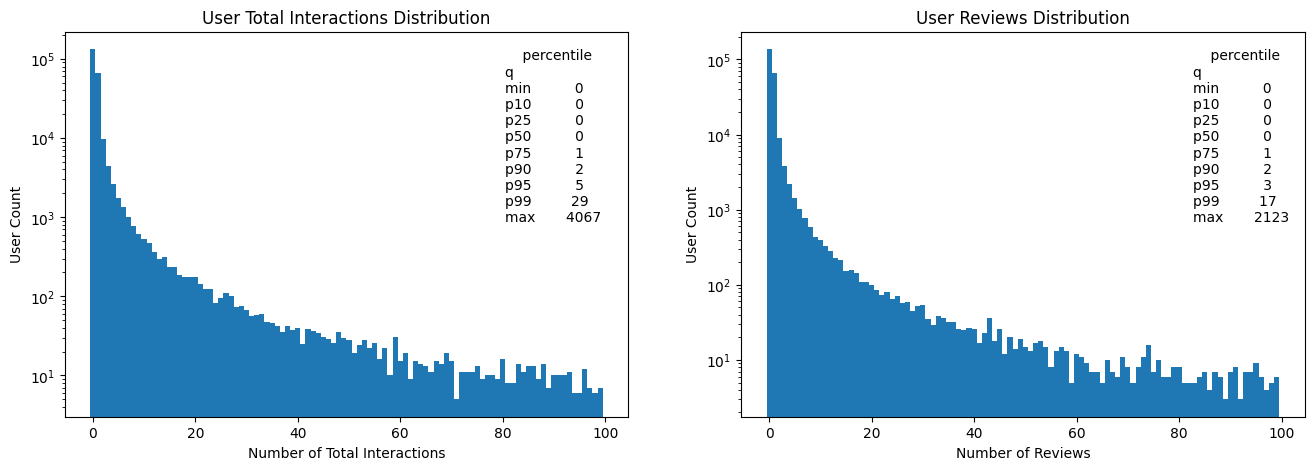

In [9]:
n_rew = 100

all_interactions_df = degree_counts( 'User', 'REVIEWED|SUBMITTED', 'OUT')
reviews_df = degree_counts('User', 'REVIEWED', 'OUT')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:n_rew], all_interactions_df.degreeCount[:n_rew], width=1, log=True)
axs[0].set_title('User Total Interactions Distribution')
axs[0].set_ylabel('User Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())

axs[1].bar(reviews_df.degree[:n_rew], reviews_df.degreeCount[:n_rew], width=1, log=True)
axs[1].set_title('User Reviews Distribution')
axs[1].set_ylabel('User Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

The above shows the distributions for total interactions (`REVIEWED` and `SUBMITTED`) as well as reviews (just `REVIEWED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of interactions. This is somewhat expected. 

We can do a similar breakdown for Recipe below.

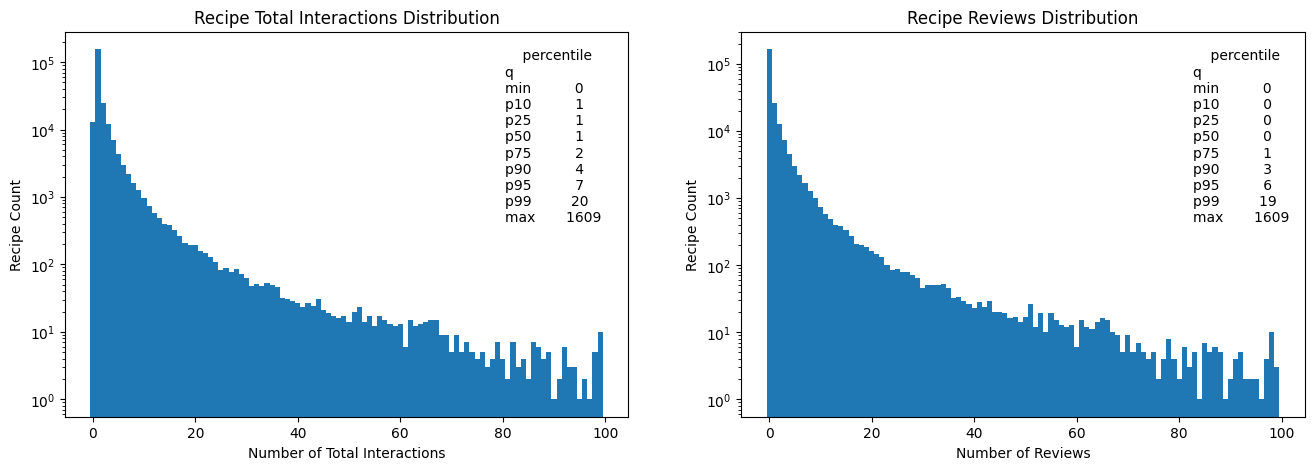

In [10]:
all_interactions_df = degree_counts('Recipe', 'REVIEWED|SUBMITTED', 'IN')
reviews_df = degree_counts('Recipe', 'REVIEWED', 'IN')
submit_df = degree_counts('Recipe', 'SUBMITTED', 'IN')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:n_rew], all_interactions_df.degreeCount[:n_rew], width=1, log=True)
axs[0].set_title('Recipe Total Interactions Distribution')
axs[0].set_ylabel('Recipe Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())


axs[1].bar(reviews_df.degree[:n_rew], reviews_df.degreeCount[:n_rew], width=1, log=True)
axs[1].set_title('Recipe Reviews Distribution')
axs[1].set_ylabel('Recipe Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

## Collaborative Filtering (CF)

There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### User vs Item Based CF
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) submitted, rated, etc.

## Basic Cypher Queries for CF
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [11]:
# Select a random user that has at least n_reviews reviews
random_user_query = gds.run_cypher('''
    MATCH (u:User)-[:REVIEWED]->(:Recipe)
    WITH u, COUNT(*) AS reviewCount
    WHERE reviewCount >= $n_reviews
    WITH u, RAND() AS randomOrder, reviewCount
    ORDER BY randomOrder
    RETURN u.id AS randomUserID, reviewCount
    LIMIT 1
''', params={'n_reviews': 100})

USER_ID = str(random_user_query['randomUserID'][0])

print(f"Selected user {USER_ID} with", random_user_query['reviewCount'][0], 'reviews')

Selected user 177933 with 123 reviews


In [12]:
gds.run_cypher('''
    MATCH (u:User {id: $userId})-[i:SUBMITTED|REVIEWED]->(r:Recipe)
    RETURN r.id AS recipeID,
           r.name AS name,
           r.nutrition AS nutrition,
           r.n_ingredients AS n_ingredients,
           COALESCE(i.submitted, i.date) AS impressionTime,
           type(i) AS interactionType
    ORDER BY interactionType, impressionTime DESC
    ''', params={'userId': USER_ID})


,recipeID,name,nutrition,n_ingredients,impressionTime,interactionType
0,19678,lee lee s famous chocolate sauce for ice cream,"[145.7, 7.0, 99.0, 4.0, 1.0, 13.0, 8.0]",6,2013-07-17,REVIEWED
1,303245,low slow oven baked ribs super simple,"[1293.3, 134.0, 65.0, 41.0, 204.0, 154.0, 7.0]",2,2012-12-07,REVIEWED
2,73825,why i joined zaar carrot cake,"[662.1, 58.0, 224.0, 24.0, 13.0, 56.0, 25.0]",16,2012-10-27,REVIEWED
3,52064,tsr versionof chili s boneless buffalo wings by todd wilbur,"[398.1, 20.0, 2.0, 134.0, 27.0, 24.0, 18.0]",13,2012-08-24,REVIEWED
4,256914,tsr version of red lobster cheddar bay biscuits by todd wilbur,"[283.9, 27.0, 21.0, 22.0, 13.0, 46.0, 7.0]",7,2012-08-13,REVIEWED
...,...,...,...,...,...,...
171,112907,bobby flay s beer simmered bratwurst,"[702.6, 76.0, 9.0, 60.0, 50.0, 85.0, 6.0]",12,2005-03-08,SUBMITTED
172,110422,the easiest and most wonderful salmon sauce,"[443.3, 71.0, 30.0, 31.0, 2.0, 145.0, 3.0]",6,2005-02-07,SUBMITTED
173,108883,my very best alfredo,"[730.0, 110.0, 2.0, 30.0, 34.0, 224.0, 2.0]",5,2005-01-20,SUBMITTED
174,107943,my very best clam chowder,"[926.1, 90.0, 12.0, 24.0, 99.0, 175.0, 13.0]",12,2005-01-10,SUBMITTED


Assuming we can measure the similarity of user interests via commonly reviewed recipes, we can do a three hop query to find potential recommendations for user `27711` based on the activity of users that reviewed the same recipe as `27711` (or even reviewed their recipe high).

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations.

In [13]:
gds.run_cypher('''
       MATCH (u1:User {id: $userId})-[rw1:REVIEWED]->(r1:Recipe)
       WITH u1, COLLECT(r1) AS reviewedRecipes
       MATCH (u1)-[rw2:SUBMITTED]->(submitRecipe:Recipe)
       WITH u1, reviewedRecipes, COLLECT(submitRecipe) AS submitRecipes
       MATCH (u1)-[rw1]->(r1:Recipe)<-[rw2:REVIEWED]-(u2:User)-[r3:REVIEWED]->(r2:Recipe)
       WHERE NOT (r2 IN reviewedRecipes) AND NOT (r2 IN submitRecipes)
       RETURN u1.id AS userId,
              COUNT(DISTINCT r1) AS reviewedRecipesCount,
              COUNT(DISTINCT u2) AS likeUsersCount,
              COUNT(DISTINCT r2) AS potentialRecommendationsCount
    ''', params={'userId': USER_ID})

,userId,reviewedRecipesCount,likeUsersCount,potentialRecommendationsCount
0,177933,133,4099,46104


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (about 13K). And this is just a sample of the the total dataset.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

### Recommendation based on favorite ingredients
First let's make a list of excluded ingredients. Those ingredients won't be considered as they're common ingredients in recipies.

In [14]:
# Define a list of (common) ingredients to exclude
excluded_ingr = [
    'butter', 'salt', 'sugar', 'all-purpose flour', 'baking powder', 'baking soda', 
    'olive oil', 'pepper', 'water', 'flour', 'eggs', 'egg'
]
# Define how many favorite ingredients we want to take into account
n_fav_ingr = 10
# Define how many recipe to suggest
n_sugestions = 5

In [15]:
start_time = time.time()

# Compute top 5 user ingredients
favIngr = gds.run_cypher('''
    MATCH (u:User {id: $userId})-[:REVIEWED {rating: 5}]->(r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT i.name IN $excluded_ingr
    WITH i, COUNT(r) AS reviewCount, COLLECT(r.id) as reviewedRecipes
    ORDER BY reviewCount DESC
    LIMIT $limit
    RETURN i.name AS favoriteIngredient, reviewCount, reviewedRecipes
    ''', params={'userId': USER_ID, 'limit': n_fav_ingr, 
                 'excluded_ingr': excluded_ingr})

end_time = time.time()

# Save data
favorite_ingredients = list(favIngr['favoriteIngredient'])
reviewed_recipes = list(set(item for sublist in favIngr['reviewedRecipes'] for item in sublist))

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
favIngr[['favoriteIngredient', 'reviewCount']]


Query executed in 0.26 seconds


,favoriteIngredient,reviewCount
0,onion,21
1,brown sugar,13
2,garlic,12
3,milk,10
4,lemon juice,8
5,garlic cloves,8
6,salt and pepper,8
7,soy sauce,8
8,fresh lemon juice,7
9,ground cinnamon,7


In [67]:
start_time = time.time()

# Suggest recipes based on user's favorites ingredients
favIngrRec = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients
    WHERE ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds)
    RETURN r.id AS RecipeID, r.name AS RecipeName, recipeIngredients,
        SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS MatchCount,
        SIZE(recipeIngredients) AS TotalIngredients,
        toFloat(SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds])) / SIZE(recipeIngredients) * SIZE(recipeIngredients) AS RelevanceScore
    ORDER BY RelevanceScore DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Save suggested recipes
suggestedRec = list(favIngrRec['RecipeID'])

# Show result
favIngrRec


Query executed in 5.19 seconds


,RecipeID,RecipeName,recipeIngredients,MatchCount,TotalIngredients,RelevanceScore
0,467162,steak and vegetable kabobs,"[cherry tomatoes, canola oil, top sirloin steaks, dried basil, fresh mushrooms, brown sugar, salt and pepper, lemon juice, soy sauce, green pepper, zucchini, garlic cloves, onion]",6,13,6.0
1,484,katjang sauce peanut sauce,"[sambal oelek, smooth peanut butter, lemon juice, onion, brown sugar, mild paprika, ketjap manis, milk, salt and pepper, ginger powder, garlic cloves]",6,11,6.0
2,162422,blueberry rum marinated pork tenderloin,"[fresh lemon juice, red bell pepper, jalapeno peppers, pork tenderloin, lemon juice, white vinegar, onion, fresh cilantro, french bread, rum, fresh blueberries, garlic cloves, brown sugar, kosher salt, sweet onion]",5,15,5.0
3,373451,baked jerk tofu,"[brown sugar, ground cinnamon, fresh green chilies, soy sauce, red wine vinegar, fresh ginger, ground pepper, onion, firm tofu, ground cloves, garlic cloves, dried thyme]",5,12,5.0
4,169561,african apricot chicken skewers,"[curry powder, garlic cloves, onion, cornstarch, apricot jam, boneless chicken breasts, cumin, salt and pepper, dried apricot halves, fresh lemon juice, oil, brown sugar, onions, coriander, bay leaves]",5,15,5.0


### Recommendation based on nutritonal properties
In addition to suggestin recipes based on preferred ingredients, it's also possible to identify user preferences on nutritional values and make suggestions based on this data. We will study a user favorite nutritional values based on both the recipes he has submitted and reviewed.

In [19]:
start_time = time.time()

# Obtain nutritional values
nutrVal = gds.run_cypher('''
    MATCH (u:User {id:$userID})-[:SUBMITTED|reviewed]->(r:Recipe)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    RETURN  r.id AS recipeID,
            nutritionList[0] AS calories, 
            nutritionList[1] AS totalFat,
            nutritionList[2] AS sugar,
            nutritionList[3] AS sodium,
            nutritionList[4] AS protein
    ''', params={
        'userID': USER_ID,
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
nutrVal


Query executed in 0.20 seconds


,recipeID,calories,totalFat,sugar,sodium,protein
0,200443,360.9,46.0,15.0,34.0,11.0
1,200337,303.4,34.0,20.0,30.0,11.0
2,364742,157.6,21.0,27.0,20.0,2.0
3,193899,140.9,13.0,15.0,10.0,19.0
4,184947,568.2,17.0,0.0,22.0,4.0
...,...,...,...,...,...,...
48,205585,164.1,9.0,26.0,19.0,15.0
49,110422,443.3,71.0,30.0,31.0,2.0
50,138801,137.0,0.0,39.0,7.0,9.0
51,205578,232.7,17.0,4.0,55.0,55.0


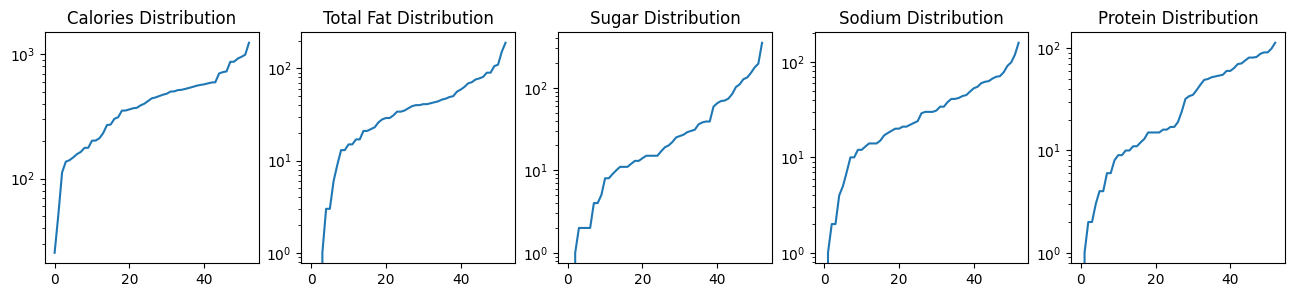

50% of calories data lies between 232.70 and 568.20
50% of total fat data lies between 17.00 and 56.00
50% of sugar data lies between 10.00 and 59.00
50% of sodium data lies between 14.00 and 49.00
50% of protein data lies between 10.00 and 60.00


In [20]:
d_range = (25, 75)

f, axs = plt.subplots(1,5,figsize=(16,3))

axs[0].plot(sorted(nutrVal['calories']))
axs[0].set_yscale('log')
axs[0].set_title('Calories Distribution')

axs[1].plot(sorted(nutrVal['totalFat']))
axs[1].set_yscale('log')
axs[1].set_title('Total Fat Distribution')

axs[2].plot(sorted(nutrVal['sugar']))
axs[2].set_yscale('log')
axs[2].set_title('Sugar Distribution')

axs[3].plot(sorted(nutrVal['sodium']))
axs[3].set_yscale('log')
axs[3].set_title('Sodium Distribution')

axs[4].plot(sorted(nutrVal['protein']))
axs[4].set_yscale('log')
axs[4].set_title('Protein Distribution')

plt.show()

calories_range = (
      np.percentile(nutrVal['calories'], d_range[0]), 
      np.percentile(nutrVal['calories'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of calories data lies between " +
      f"{calories_range[0]:.2f} and {calories_range[1]:.2f}")

fat_range = (
      np.percentile(nutrVal['totalFat'], d_range[0]), 
      np.percentile(nutrVal['totalFat'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of total fat data lies between " +
      f"{fat_range[0]:.2f} and {fat_range[1]:.2f}")

sugar_range = (
      np.percentile(nutrVal['sugar'], d_range[0]), 
      np.percentile(nutrVal['sugar'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of sugar data lies between " +
      f"{sugar_range[0]:.2f} and {sugar_range[1]:.2f}")

sodium_range = (
      np.percentile(nutrVal['sodium'], d_range[0]), 
      np.percentile(nutrVal['sodium'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of sodium data lies between " +
      f"{sodium_range[0]:.2f} and {sodium_range[1]:.2f}")

protein_range = (
      np.percentile(nutrVal['protein'], d_range[0]), 
      np.percentile(nutrVal['protein'], d_range[1]))
print(f"{d_range[1]-d_range[0]}% of protein data lies between " +
      f"{protein_range[0]:.2f} and {protein_range[1]:.2f}")

In [21]:
start_time = time.time()

# Suggest recipe based on nutritional values
nutrValRec = gds.run_cypher('''
    MATCH (r:Recipe)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    WHERE   nutritionList[0] > $min_0 AND nutritionList[0] < $max_0    // CALORIES
        AND nutritionList[1] > $min_1 AND nutritionList[1] < $max_1    // TOTAL FAT (PDV)
        AND nutritionList[2] > $min_1 AND nutritionList[2] < $max_2    // SUGAR (PVD)
        AND nutritionList[3] > $min_3 AND nutritionList[3] < $max_3    // SODIUM (PDV)
        AND nutritionList[4] > $min_4 AND nutritionList[4] < $max_4    // PROTEIN
    RETURN r.id as RecipeID, r.name AS RecipeName, nutritionList
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'min_0': calories_range[0], 'max_0': calories_range[1],
        'min_1': fat_range[0], 'max_1': fat_range[1],
        'min_2': sugar_range[0], 'max_2': sugar_range[1],
        'min_3': sodium_range[0], 'max_3': sodium_range[1],
        'min_4': protein_range[0], 'max_4': protein_range[1]})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
nutrValRec


Query executed in 0.22 seconds


,RecipeID,RecipeName,nutritionList
0,112140,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]"
1,8559,chinese chop suey,"[395.4, 31.0, 20.0, 29.0, 51.0, 33.0, 8.0]"
2,47366,forgotten minestrone,"[346.9, 24.0, 18.0, 42.0, 42.0, 30.0, 10.0]"
3,108414,jiffy roasted corn and jalapeno cornbread,"[400.2, 32.0, 43.0, 31.0, 21.0, 54.0, 14.0]"
4,32169,make that chicken dance salsa pasta,"[255.2, 18.0, 39.0, 18.0, 39.0, 13.0, 6.0]"


We can also combine the user preferences on ingredients with those on nutritional values to provide even more accurate recommendations. We can than sort the result based on most matching favorites ingredients and show first recipes with less preparation time.

In [68]:
start_time = time.time()
######################################################à TO MODIFY
# Suggest recipe based on favorite ingredients and nutritional values
fitRecFavIngr = gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients, apoc.convert.fromJsonList(r.nutrition) AS nutritionList
    WHERE 
        ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds) 
        AND nutritionList[0] > $min_0 AND nutritionList[0] < $max_0    // CALORIES
        AND nutritionList[1] > $min_1 AND nutritionList[1] < $max_1    // TOTAL FAT (PDV)
        AND nutritionList[2] > $min_1 AND nutritionList[2] < $max_2    // SUGAR (PVD)
        AND nutritionList[3] > $min_3 AND nutritionList[3] < $max_3    // SODIUM (PDV)
        AND nutritionList[4] > $min_4 AND nutritionList[4] < $max_4    // PROTEIN
    RETURN r.id as RecipeID, r.name AS RecipeName, recipeIngredients, SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS matchCount, nutritionList
    ORDER BY matchCount DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'favIngreds': favorite_ingredients,
        'excluded_ingr': excluded_ingr,
        'min_0': calories_range[0], 'max_0': calories_range[1],
        'min_1': fat_range[0], 'max_1': fat_range[1],
        'min_2': sugar_range[0], 'max_2': sugar_range[1],
        'min_3': sodium_range[0], 'max_3': sodium_range[1],
        'min_4': protein_range[0], 'max_4': protein_range[1]})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Show result
fitRecFavIngr


Query executed in 13.41 seconds


,RecipeID,RecipeName,recipeIngredients,matchCount,nutritionList
0,223752,homemade pasta spaghetti sauce this ain t no prego,"[balsamic vinegar, brown sugar, carrot, canned tomatoes, tomato paste, parmesan cheese, ground beef, ground cinnamon, olive oil, bay leaf, dried chili pepper flakes, salt and pepper, parsley, green pepper, onion, italian seasoning, red wine, tomato sauce, garlic cloves, celery rib]",5,"[236.3, 18.0, 37.0, 24.0, 30.0, 23.0, 4.0]"
1,62802,japanese pork sate,"[lemon juice, garlic, hot pepper sauce, boneless pork loin, peanut butter, onion, vegetable oil, brown sugar, cooked rice, soy sauce]",5,"[331.5, 33.0, 21.0, 25.0, 51.0, 31.0, 2.0]"
2,300985,classic cottage pie,"[porcini mushrooms, salt and pepper, ketchup, carrots, garlic, worcestershire sauce, onion, flour, ground sirloin, butter, yukon gold potatoes, celery, extra virgin olive oil, sour cream, chicken stock, milk, red wine, garlic cloves]",5,"[542.2, 40.0, 35.0, 20.0, 48.0, 54.0, 17.0]"
3,321850,emeril s jamaican jerk pork tenderloins,"[scotch bonnet peppers, fresh parsley leaves, bay leaves, vegetable oil, coriander seed, fresh ginger, pork tenderloin, fresh thyme leave, green onion, ground nutmeg, onion, soy sauce, brown sugar, vinegar, fresh ground black pepper, ground allspice, garlic, lime juice, fresh lime juice, ground cinnamon, salt]",5,"[438.7, 23.0, 21.0, 34.0, 37.0, 14.0, 27.0]"
4,184409,barbecued tofu,"[soy sauce, water, molasses, ground coriander, cayenne, prepared mustard, tomato paste, oil, ground cumin, tofu, chili powder, garlic cloves, onion, bell pepper, tabasco sauce, lemon juice, ground fennel, cider vinegar]",4,"[260.7, 23.0, 50.0, 40.0, 23.0, 11.0, 7.0]"


### Recommendation based on website tags
Another thing we can leverage to suggest recipes to our user is Site Tags. All recipe tags are easily obtained from the following query.

In [41]:
# Suggest 'fit' recipe
gds.run_cypher('''
    MATCH (r:Recipe)
    WITH r, apoc.convert.fromJsonList(r.tags) AS tagList
    UNWIND tagList AS tag
    RETURN tag, COUNT(*) AS tagCount
    ORDER BY tagCount DESC
    ''')

,tag,tagCount
0,preparation,230546
1,time-to-make,225326
2,course,218148
3,main-ingredient,170446
4,dietary,165091
...,...,...
547,chicken-stews,1
548,chicken-stew,1
549,Throw the ultimate fiesta with this sopaipillas recipe from Food.com.,1
550,roast-beef-main-dish,1


Here we can see that there are very common tags that we're likely to exclude from the taglist, that way we can obtain more user-specific recommendation.

In [55]:
# Define a list of (common) tags to exclude
excluded_tags = [
    'preparation', 'time-to-make', 'course', 'main-ingredient'
]
# Define how many tags we want to take into account
n_tags = 10

We can also just check all tags of the recipes an user has reviewed, count them, and order by count to obtain the top tags of an user.

In [61]:
start_time = time.time()

# Suggest 'fit' recipe
userTags = gds.run_cypher('''
    MATCH (u:User {id:$user_id})-[:REVIEWED {rating:5}]->(r:Recipe)
    WITH r, apoc.convert.fromJsonList(r.tags) AS tagList
    UNWIND tagList AS tag
    WITH tag
    WHERE NOT tag IN $excluded_tags
    RETURN tag, COUNT(*) AS tagCount
    ORDER BY tagCount DESC
    LIMIT $max_tags
    ''',
    params={
        'user_id': USER_ID, 
        'max_tags': 10,
        'excluded_tags': excluded_tags})

end_time = time.time()

# Print execution time
print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

# Save tags
top_tags = list(userTags['tag'])

# Show result
userTags


Query executed in 0.02 seconds


,tag,tagCount
0,dietary,81
1,occasion,56
2,easy,54
3,equipment,52
4,cuisine,47
5,main-dish,38
6,oven,36
7,low-in-something,36
8,meat,33
9,60-minutes-or-less,30


In [66]:

gds.run_cypher('''
    MATCH (r:Recipe)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, apoc.convert.fromJsonList(r.tags) AS tagList
    WHERE ANY(tag IN tagList WHERE tag IN $topTags)
    RETURN r.id AS RecipeID, r.name AS RecipeName, tagList,
        SIZE([tag IN tagList WHERE tag IN $topTags]) AS matchCount,
        SIZE(tagList) AS totalTags,
        toFloat(SIZE([tag IN tagList WHERE tag IN $topTags])) / SIZE(tagList) * SIZE(tagList) AS relevanceScore
    ORDER BY relevanceScore DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'reviewedRecipes': reviewed_recipes,
        'topTags': top_tags})

,RecipeID,RecipeName,tagList,matchCount,totalTags,relevanceScore
0,78296,acorn squash stuffed with lamb curry,"[curries, 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, for-1-or-2, lunch, main-dish, side-dishes, lamb-sheep, poultry, vegetables, american, asian, indian, oven, easy, pakistani, microwave, dinner-party, fall, holiday-event, winter, turkey, dietary, one-dish-meal, new-years, thanksgiving, seasonal, comfort-food, low-carb, midwestern, inexpensive, low-in-something, meat, squash, brunch, novelty, taste-mood, equipment, number-of-ser...",10,47,10.0
1,289133,berinzila eggplant and ham,"[ham, 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, casseroles, main-dish, pork, vegetables, oven, easy, european, dinner-party, holiday-event, dietary, one-dish-meal, low-sodium, low-calorie, comfort-food, low-carb, low-in-something, meat, squash, taste-mood, equipment, presentation, served-hot]",10,30,10.0
2,82287,15 minute no fry chicken enchiladas honest,"[60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, main-dish, eggs-dairy, poultry, mexican, oven, easy, beginner-cook, potluck, dinner-party, cheese, chicken, dietary, one-dish-meal, low-carb, low-in-something, meat, brunch, to-go, equipment]",10,27,10.0
3,81357,acorn squash stuffed with curried meat,"[curries, 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, for-1-or-2, lunch, main-dish, side-dishes, beef, lamb-sheep, poultry, vegetables, asian, indian, oven, easy, pakistani, microwave, dinner-party, fall, holiday-event, winter, turkey, stove-top, dietary, new-years, seasonal, comfort-food, low-carb, ramadan, inexpensive, ground-beef, low-in-something, meat, squash, brunch, kwanzaa, taste-mood, savory, equipment, number-of-servings, presentation,...",10,47,10.0
4,21875,another chicken wings recipe,"[60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, appetizers, lunch, main-dish, condiments-etc, fruit, poultry, american, southern-united-states, oven, easy, beginner-cook, potluck, dinner-party, finger-food, kid-friendly, picnic, grains, chicken, dietary, low-sodium, comfort-food, pacific-northwest, low-carb, low-in-something, meat, wings, pasta-rice-and-grains, taste-mood, to-go, equipment, presentation]",10,39,10.0


### Combine all suggestions together

In [73]:

gds.run_cypher('''
    MATCH (r:Recipe)-[:WITH_INGREDIENTS]->(i:Ingredient)
    WHERE NOT r.id IN $reviewedRecipes
    WITH r, COLLECT(i.name) AS recipeIngredients, apoc.convert.fromJsonList(r.nutrition) AS nutritionList, apoc.convert.fromJsonList(r.tags) AS tagList
    WHERE ANY(ingredient IN recipeIngredients WHERE ingredient IN $favIngreds)
        AND nutritionList[0] > $min_0 AND nutritionList[0] < $max_0    // CALORIES
        AND nutritionList[1] > $min_1 AND nutritionList[1] < $max_1    // TOTAL FAT (PDV)
        AND nutritionList[2] > $min_1 AND nutritionList[2] < $max_2    // SUGAR (PVD)
        AND nutritionList[3] > $min_3 AND nutritionList[3] < $max_3    // SODIUM (PDV)
        AND nutritionList[4] > $min_4 AND nutritionList[4] < $max_4    // PROTEIN
        AND ANY(tag IN tagList WHERE tag IN $topTags)
    RETURN r.id AS RecipeID, r.name AS RecipeName,
        SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds]) AS matchingIngreds,
        toFloat(SIZE([ingredient IN recipeIngredients WHERE ingredient IN $favIngreds])) / SIZE(recipeIngredients) * SIZE(recipeIngredients) AS ingredScore,
        toFloat(SIZE([tag IN tagList WHERE tag IN $topTags])) / SIZE(tagList) * SIZE(tagList) AS tagScore
    ORDER BY (ingredScore + tagScore) DESC
    LIMIT $limit
    ''', params={
        'limit': n_sugestions, 
        'favIngreds': favorite_ingredients,
        'reviewedRecipes': reviewed_recipes,
        'topTags': top_tags,
        'min_0': calories_range[0], 'max_0': calories_range[1],
        'min_1': fat_range[0], 'max_1': fat_range[1],
        'min_2': sugar_range[0], 'max_2': sugar_range[1],
        'min_3': sodium_range[0], 'max_3': sodium_range[1],
        'min_4': protein_range[0], 'max_4': protein_range[1]})

,RecipeID,RecipeName,matchingIngreds,ingredScore,tagScore
0,248334,easy chicken chow mein saute,3,3.0,9.0
1,20903,baked pasta sauce,3,3.0,9.0
2,8554,belly buster,2,2.0,10.0
3,76222,chicken stuffed bell peppers,2,2.0,10.0
4,134945,german cabbage casserole kohl und hackfleisch,2,2.0,10.0
